# Import neccessary libraries

In [14]:
import os
import argparse
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from tensorflow.keras import layers, models, datasets, initializers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


#data preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


# Loading dataset and analyze it

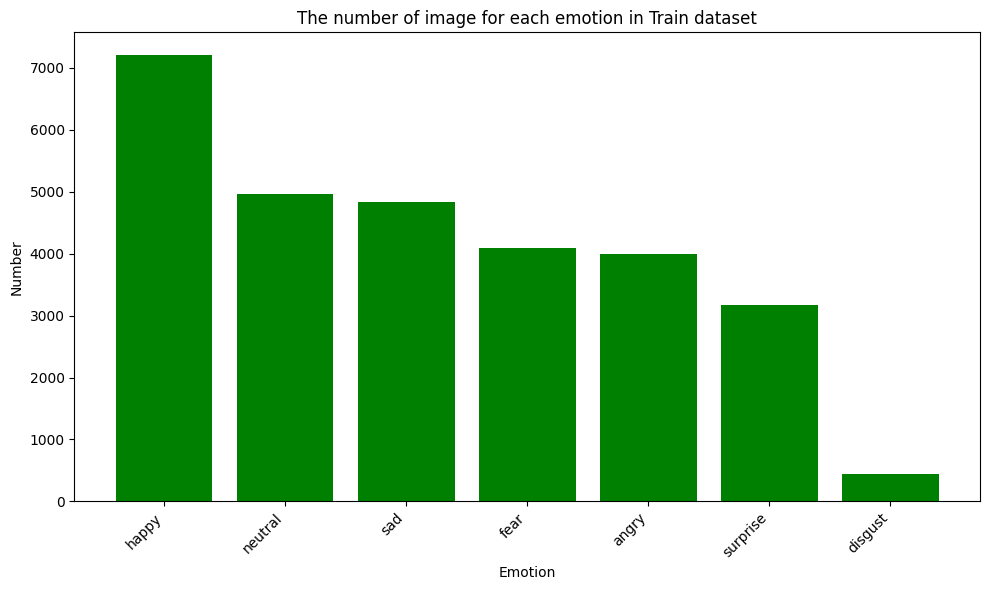

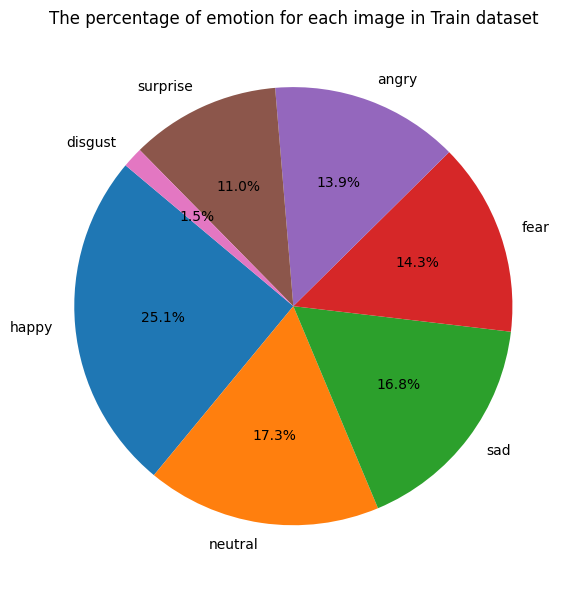

In [2]:
train_dir = '/kaggle/input/fer2013/train/'
test_dir = '/kaggle/input/fer2013/test/'

import os
import pandas as pd
import matplotlib.pyplot as plt

def analyze_and_plot_dataset(name, directory, chart_type='bar'):
    class_counts = {}
    
    for emotion_class in os.listdir(directory):
        class_path = os.path.join(directory, emotion_class)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[emotion_class] = num_images

    df = pd.DataFrame(list(class_counts.items()), columns=['Emotion', 'Count'])
    df = df.sort_values(by='Count', ascending=False)

    total_images = df['Count'].sum()
    df['Percentage'] = (df['Count'] / total_images) * 100

    plt.figure(figsize=(10, 6))

    if chart_type == 'bar':
        plt.bar(df['Emotion'], df['Count'], color='g')
        plt.xlabel('Emotion')
        plt.ylabel('Number')
        plt.title('The number of image for each emotion in ' + name)
        plt.xticks(rotation=45, ha='right')
    elif chart_type == 'pie':
        plt.pie(df['Count'], labels=df['Emotion'], autopct='%1.1f%%', startangle=140)
        plt.title('The percentage of emotion for each image in ' + name)

    plt.tight_layout()
    plt.show()


analyze_and_plot_dataset('Train dataset',train_dir, chart_type='bar')
analyze_and_plot_dataset('Train dataset',train_dir, chart_type='pie')


There's clearly an imbalance in the dataset where the 'disgust' class only dominates 1.5%.  This imbalance can skew the model's predictions and reduce its overall accuracy, especially for the minority classes.

# Spliting the dataset
The dataset includes of 2 folder, namely 'train' and 'test'. For the purpose of training and testing the model, we divide the 'train' dataset into 2 parts: train and validation. The 'test' dataset will be used for testing only. 

In [3]:
#tensorflow
from sklearn.model_selection import train_test_split

img_size=48
batch=64

def load_images_and_labels(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for image_filename in os.listdir(label_path):
                image_path = os.path.join(label_path, image_filename)
                images.append(image_path)
                labels.append(label)
    return images, labels

train_images, train_labels = load_images_and_labels(train_dir) #load the train dataset

#split the train dataset into 2: train and validation
train_images, valid_images, train_labels, valid_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

#test dataset:
test_images, test_labels = load_images_and_labels(test_dir)

#image data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode = 'nearest',
    horizontal_flip=True
)

# image data generator for validation and test
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_images, "class": train_labels}),
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": valid_images, "class": valid_labels}),
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False,
    seed=42
)

test_generator = valid_datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_images, "class": test_labels}),
    directory=test_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode="grayscale",
    shuffle=False,
)


Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


In [4]:
from sklearn.utils.class_weight import compute_class_weight
num_classes = 7
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
print(class_weights)

[1.0409264  9.56559767 0.99908648 0.5657872  0.83021255 0.84540067
 1.28364632]


# Modeling

In [5]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate,GlobalAveragePooling2D
from tensorflow.keras.models import Model

def inception_module(x, filters):
    # 1x1 convolution
    conv1x1_1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    # 1x1 convolution followed by 3x3 convolution
    conv1x1_2 = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv1x1_2)

    # 1x1 convolution followed by 5x5 convolution
    conv1x1_3 = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv1x1_3)

    # 3x3 max pooling followed by 1x1 convolution
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    conv1x1_4 = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)

    # Concatenate all branches
    inception = concatenate([conv1x1_1, conv3x3, conv5x5, conv1x1_4], axis=-1)
    return inception

def auxiliary_classifier(x, num_classes):
    # 5x5 average pooling
    x = AveragePooling2D((5, 5), strides=(3, 3), padding='valid')(x)

    # 1x1 convolution
    x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)  

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    return output_layer

def GoogleNet(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu',name='conv_1_7x7/2')(input_layer)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same',name='max_pool_1_3x3/2')(x)
    
    #Inception module
    x = inception_module(x, [32, 48, 64, 8, 16, 16])
    x = inception_module(x, [64, 64, 96, 16, 48, 32])
    
    aux1 = auxiliary_classifier(x, num_classes)
    
    x = inception_module(x, [64, 64, 96, 16, 48, 32])
    
    aux2 = auxiliary_classifier(x, num_classes)
    
    x= inception_module(x,[80,56,112,12,32,32])
    x= inception_module(x,[64,64,112,12,32,32])

    x = inception_module(x, [64, 64, 96, 16, 48, 32])
   
    x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

    #output layer
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = (48, 48, 1)  
num_classes = 7  
model = GoogleNet(input_shape, num_classes)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48, 48, 1)]          0         []                            
                                                                                                  
 conv_1_7x7/2 (Conv2D)       (None, 24, 24, 32)           320       ['input_1[0][0]']             
                                                                                                  
 max_pool_1_3x3/2 (MaxPooli  (None, 12, 12, 32)           0         ['conv_1_7x7/2[0][0]']        
 ng2D)                                                                                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 12, 12, 48)           1584      ['max_pool_1_3x3/2[0][0]']

# Training the model

In [9]:
checkpoint = ModelCheckpoint('/kaggle/working/google_net_1.h5', monitor='val_accuracy', save_best_only=True, mode='max',verbose=1)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch,
    epochs=60,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch,
    class_weight=dict(enumerate(class_weights)),
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/60
358/358 [==============================] - ETA: 0s - loss: 1.9366 - accuracy: 0.1432
Epoch 1: val_accuracy improved from -inf to 0.15660, saving model to /kaggle/working/google_net_1.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


358/358 [==============================] - 212s 517ms/step - loss: 1.9366 - accuracy: 0.1432 - val_loss: 1.9236 - val_accuracy: 0.1566
Epoch 2/60
358/358 [==============================] - ETA: 0s - loss: 1.9200 - accuracy: 0.1809
Epoch 2: val_accuracy improved from 0.15660 to 0.16029, saving model to /kaggle/working/google_net_1.h5
358/358 [==============================] - 52s 145ms/step - loss: 1.9200 - accuracy: 0.1809 - val_loss: 1.9568 - val_accuracy: 0.1603
Epoch 3/60
358/358 [==============================] - ETA: 0s - loss: 1.9138 - accuracy: 0.2033
Epoch 3: val_accuracy improved from 0.16029 to 0.18890, saving model to /kaggle/working/google_net_1.h5
358/358 [==============================] - 53s 148ms/step - loss: 1.9138 - accuracy: 0.2033 - val_loss: 1.9207 - val_accuracy: 0.1889
Epoch 4/60
358/358 [==============================] - ETA: 0s - loss: 1.8965 - accuracy: 0.2207
Epoch 4: val_accuracy improved from 0.18890 to 0.21454, saving model to /kaggle/working/google_net_1.

# Results and evaluation

## Train and validation loss visualization

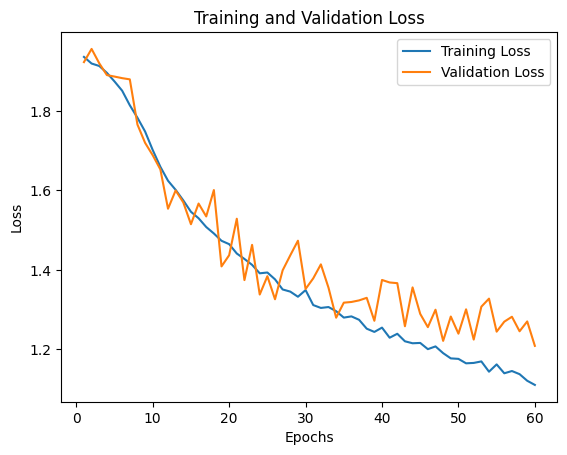

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Train and validation accuracy visualization

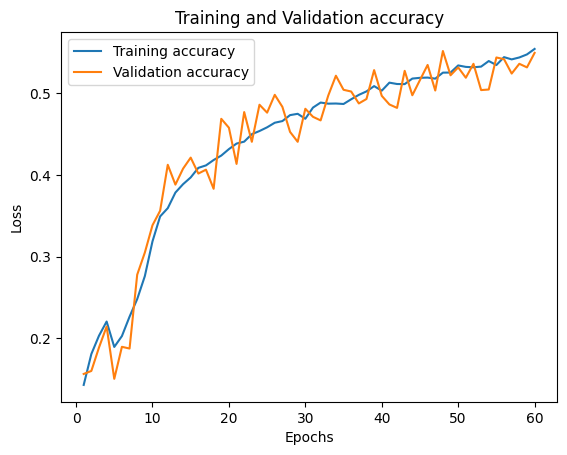

In [11]:
train_loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, label='Training accuracy')
plt.plot(epochs, val_loss, label='Validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation accuracy')
plt.legend()

plt.show()

# Confusion matrix

113/113 [==============================] - 65s 577ms/step


Text(0.5, 1.0, 'Confusion Matrix')

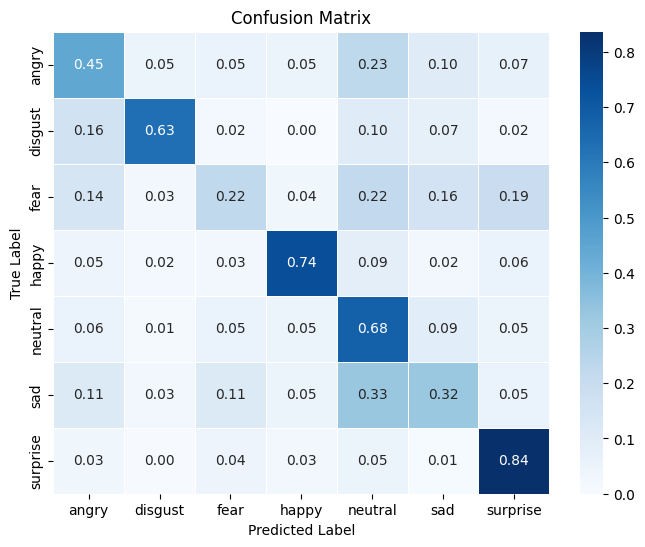

In [12]:
predictions = model.predict(test_generator)
true_labels = np.array(test_generator.labels)
pred_labels = np.argmax(predictions, axis=1)

class_labels = sorted(os.listdir(train_dir))
conf_matrix = confusion_matrix(true_labels, pred_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))

sns.heatmap(conf_matrix_normalized, annot=True, cmap='Blues', fmt=".2f", linewidths=.5, xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

## Classification report

In [13]:
report = classification_report(true_labels, pred_labels, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.45      0.46       958
     disgust       0.30      0.63      0.41       111
        fear       0.40      0.22      0.29      1024
       happy       0.85      0.74      0.79      1774
     neutral       0.44      0.68      0.54      1233
         sad       0.48      0.32      0.39      1247
    surprise       0.59      0.84      0.69       831

    accuracy                           0.55      7178
   macro avg       0.50      0.55      0.51      7178
weighted avg       0.56      0.55      0.54      7178

